In [1]:
#%matplotlib inline

# Importing necessary libraries
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

# Importing the custom ResNeXt and Discriminator models along with dataloaders
from model import ResNeXt, Discriminator
from dataloader import get_dataloaders

# Seed
manual_seed = 0
random.seed(manual_seed)
torch.manual_seed(manual_seed)

# Hyperparameters
lr = 0.0002
num_epochs = 5000
device = torch.device("cuda")
lambda_L1 = 100
batch_size = 64
sample_size = 30000

# Dataloaders
train_loader, test_loader = get_dataloaders(batch_size=batch_size, sample_size=sample_size)


In [2]:

# Initialize models
generator = ResNeXt().to(device)
discriminator = Discriminator().to(device)

# Initialize optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Define the loss functions
criterion_GAN = nn.MSELoss()
criterion_L1 = nn.L1Loss()

In [3]:
# phone, dslr = next(iter(train_dataloader))
# plt.figure(figsize=(4,4))
# plt.axis("off")
# plt.title("Training Images")
# # display the images with shape of torch.Size([3, 100, 100, 32])
# plt.imshow(np.transpose(vutils.make_grid(phone), (1,2,0)))

In [8]:
# Load the generator checkpoint
epoch = 1760

checkpoint_G = torch.load(f'checkpoints/generator_epoch_{epoch}.pth')
generator.load_state_dict(checkpoint_G)

# Load the discriminator checkpoint
checkpoint_D = torch.load(f'checkpoints/discriminator_epoch_{epoch}.pth')
discriminator.load_state_dict(checkpoint_D)
# Initialize optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [5]:

gen_losses = []
disc_losses = []

# Load a pre-trained VGG model
# vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

# def get_features(image, model, layers=None):
#     if layers is None:
#         layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', 
#                   '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}
#     features = {}
#     for name, layer in model._modules.items():
#         image = layer(image)
#         if name in layers:
#             features[layers[name]] = image
#     return features

# def gram_matrix(tensor):
#     _, d, h, w = tensor.size()
#     tensor = tensor.view(d, -1)  # Change here
#     gram = torch.mm(tensor, tensor.t())
#     return gram / (tensor.size(1))

# def total_variation_loss(img):
#     tv_h = torch.mean(torch.abs(img[:, :, 1:, :] - img[:, :, :-1, :]))
#     tv_w = torch.mean(torch.abs(img[:, :, :, 1:] - img[:, :, :, :-1]))
#     return tv_h + tv_w

# def gauss_kernel(size=21, sigma=3, channels=3):
#     # Ensure the kernel size is odd
#     if size % 2 == 0:
#         size += 1

#     # Create a 1D Gaussian kernel
#     x = torch.linspace(-size // 2, size // 2, steps=size)
#     gauss = torch.exp(-x.pow(2) / (2 * sigma**2))
#     gauss = gauss / gauss.sum()

#     # Create a 2D Gaussian kernel
#     gauss_2d = gauss.unsqueeze(0) * gauss.unsqueeze(1)
    
#     # Stack and expand to desired number of channels
#     gauss_3d = gauss_2d.expand(channels, 1, -1, -1)

#     return gauss_3d

# def get_color_loss(enhanced_image, dslr_image, batch_size):
#     enhanced_blur = blur(enhanced_image)
#     dslr_blur = blur(dslr_image)

#     loss = torch.sum((dslr_blur - enhanced_blur) ** 2) / (2 * batch_size)
#     return loss

# def identity_color_loss(generator, dslr_images, batch_size):
#     # Pass the DSLR images through the generator
#     identity_images = generator(dslr_images)

#     # Apply Gaussian blur to both the output and the original DSLR images
#     identity_blur = blur(identity_images)
#     dslr_blur = blur(dslr_images)

#     # Calculate the loss as the mean squared error between the blurred images
#     loss = torch.sum((dslr_blur - identity_blur) ** 2) / (2 * batch_size)
#     return loss

# def blur(image, kernel_size=21, sigma=3):
#     channels = image.shape[1]
#     kernel = gauss_kernel(kernel_size, sigma, channels)
#     kernel = kernel.to(image.device)
    
#     # Apply depthwise convolution
#     blurred = F.conv2d(image, kernel, groups=channels, padding=kernel_size//2)
    
#     return blurred



In [3]:
gen_losses = []
disc_losses = []
epoch = 0

for epoch in range(epoch, num_epochs):
    for i, (real_images, target_images) in enumerate(train_loader):
        real_images = real_images.to(device)
        target_images = target_images.to(device)

        # Adversarial ground truths
        valid = torch.ones((real_images.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((real_images.size(0), 1), requires_grad=False).to(device)

        # Forward pass
        fake_images = generator(real_images)

        # ---------------------
        # Train Discriminator
        # ---------------------
        for param in discriminator.parameters():
            param.requires_grad = True

        optimizer_D.zero_grad()

        # Calculate D gradients
        pred_fake = discriminator(fake_images.detach())
        loss_fake = criterion_GAN(pred_fake, fake)

        pred_real = discriminator(target_images)
        loss_real = criterion_GAN(pred_real, valid)
        loss_D = (real_loss + fake_loss) * 0.5
        loss_D.backward()

        # Update D weights
        optimizer_D.step()

        # -----------------
        # Train Generator
        # -----------------
        for param in discriminator.parameters():
            param.requires_grad = False

        optimizer_G.zero_grad()

        # Calculate G gradients
        pred_fake = discriminator(fake_images)
        loss_GAN = criterion_GAN(pred_fake, valid)
        loss_L1 = criterion_L1(fake_images, target_images) * lambda_L1
        loss_G = loss_GAN + loss_L1
        loss_G.backward()

        # Update G weights
        optimizer_G.step()

        gen_losses.append(loss_G.item())
        disc_losses.append(loss_D.item())

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}] - Gen Loss: {loss_G.item()}, Disc Loss: {loss_D.item()}")
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Checkpoint - Gen Loss: {loss_G.item()}, Disc Loss: {loss_D.item()}")

        # Save model checkpoints
        torch.save(generator.state_dict(), f'checkpoints/generator_epoch_{epoch + 1}.pth')
        torch.save(discriminator.state_dict(), f'checkpoints/discriminator_epoch_{epoch + 1}.pth')

        # Example of saving a sample enhanced image
        sample_enhanced = fake_images[0]
        sample_original = real_images[0]
        comparison = torch.cat((sample_original, sample_enhanced), dim=2)
        save_image(comparison, os.path.join('results', f'sample_epoch_{epoch + 1}.jpg'))



AttributeError: 'bool' object has no attribute 'size'

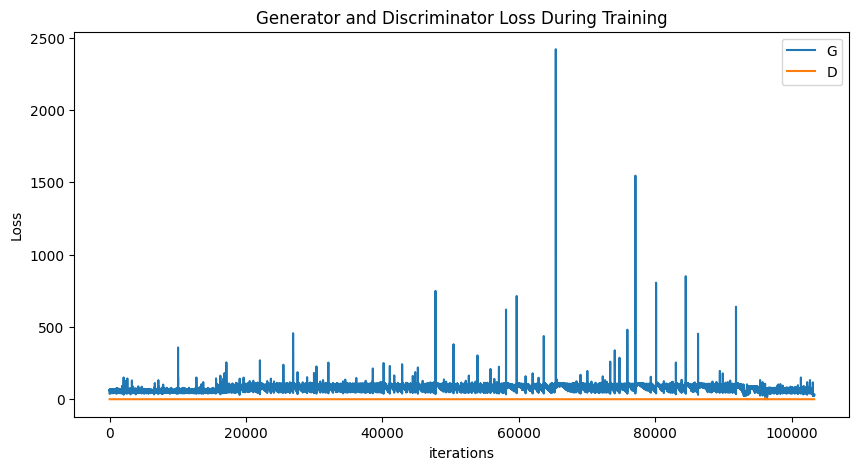

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="G")
plt.plot(disc_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:

# Plot the generator and discriminator losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="G")
plt.plot(disc_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()




In [ ]:
checkpoint = torch.load("generator_epoch_49.pth")
generator.load_state_dict(checkpoint['model_state_dict'])
optimizer_G.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']


In [ ]:
from torchvision.utils import save_image
generator.eval()
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        imgs_iphone, imgs_dslr = data
        imgs_iphone, imgs_dslr = imgs_iphone.to(device), imgs_dslr.to(device)
        gen_imgs = generator(imgs_iphone)
        
        save_image(gen_imgs, f"images/image_{i}.jpg")
